# Inferring the rotation period of [KIC 1430163](https://archive.stsci.edu/kepler/data_search/search.php?target=1430163&action=Search&outputformat=HTML_Table) from [Kepler](https://archive.stsci.edu/kepler/) using [celerite](https://github.com/dfm/celerite) model

Based on the [example](https://github.com/dfm/celerite/blob/master/paper/figures/rotation/rotation.ipynb) from Foreman-Mackey ([2017](https://www.mendeley.com/catalogue/fast-scalable-gaussian-process-modeling-applications-astronomical-time-series/)). Revised by [Pavel Sobolev](https://github.com/Paveloom) and located [here](https://github.com/Paveloom/C2).

Importing a standard module:

In [1]:
import copy # Copying

Importing non-standard packages and modules:

[kplr](https://github.com/dfm/kplr), [corner](https://github.com/dfm/corner.py), [emcee](https://github.com/dfm/emcee), and [celerite](https://github.com/dfm/celerite) developed by [Daniel Foreman-Mackey](https://github.com/dfm) and other contributors;<br>
[matplotlib](https://github.com/matplotlib/matplotlib) developed by [Michael Droettboom](https://github.com/mdboom),  [Thomas Caswell](https://github.com/tacaswell) and other contributors;<br>
[autograd](https://github.com/HIPS/autograd) developed by [Dougal Maclaurin](https://dougalmaclaurin.com), [David Duvenaud](https://www.cs.toronto.edu/~duvenaud/), [Matt Johnson](http://people.csail.mit.edu/mattjj/), [Jamie Townsend](https://github.com/j-towns) and other contributors;<br>
[optimization](https://github.com/scipy/scipy/tree/master/scipy/optimize) module from [scipy](https://github.com/scipy/scipy) developed by contributors;<br>
[timeseries](https://github.com/astropy/astropy/tree/master/astropy/timeseries) module from [astropy](https://github.com/astropy/astropy) developed by contributors.

In [2]:
import kplr # Tools for working with Kepler data
import corner # Tools for making corner plots
import emcee # The Python ensemble sampling toolkit for affine-invariant MCMC
from celerite import plot_setup, terms # Scalable 1D Gaussian Processes

from matplotlib import rcParams as rcP, pyplot as plt # Plots
from autograd import numpy as np # Derivatives of numpy code
from scipy.optimize import minimize # Minimization of a scalar function
from astropy.timeseries import LombScargle # Computing of the Lomb-Scargle Periodogram

Setting plots parameters:

In [3]:
# A magic command to get inline plots within a Python Notebook
%matplotlib inline

# A magic command to enable 2x plots
%config IPython.matplotlib.backend = "retina"

# Setting DPIs of figures
rcP["savefig.dpi"] = 300
rcP["figure.dpi"]  = 300

# Setting other plots settings
plot_setup.setup()

Loading sample data from the [Kepler Input Catalog](https://archive.stsci.edu/kepler/kic.html) (field descriptors are taken from [Kepler Archive Manual](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/archive_manual.pdf)):

In [4]:
# The ID of a star from the Kepler Input Catalog
KIC_ID = 1430163

# Attaching the kplr API
client = kplr.API()

# Getting the star data
star = client.star(KIC_ID)

# Time values
t = []

# Pre-search Data Conditioning Simple Aperture Photometry (PDCSAP) flux values
f = []

# The 1-sigma errors in PDC flux values
ferr = []

# Getting short cadence light curves
for lc in star.get_light_curves(short_cadence=False):
    
    # Reading data from a light curve
    data = lc.read()
    
    # Getting time values from the data
    t0 = data["TIME"]
    
    # Getting PDCSAP flux values from the data
    f0 = data["PDCSAP_FLUX"]
    
    # Creating a mask for only qualitative data points
    mask = (data["SAP_QUALITY"] == 0) & np.isfinite(t0) & np.isfinite(f0)

    # Appending the qualitative time data to the existing list
    t.append(t0[mask])
    
    # Computing the median of the flux data
    mu = np.median(f0[mask])
    
    # Scaling the qualitative flux data and appending these to the existing list
    f.append( ( f0[mask] / mu - 1.0 ) * 1e3 )
    
    # Scaling the qualitative flux errors data and appending these to the existing list
    ferr.append( data["PDCSAP_FLUX_ERR"][mask] / mu * 1e3 )
    
# Concatenating the arrays within the lists

t = np.concatenate(t)
f = np.concatenate(f)
ferr = np.concatenate(ferr)

# Getting contiguous arrays

t = np.ascontiguousarray(t, dtype = float)
f = np.ascontiguousarray(f, dtype = float)
ferr = np.ascontiguousarray(ferr, dtype = float)

Making a first guess at the period using the Lomb-Scargle periodogram (see, e.g VanderPlas ([2017](https://www.mendeley.com/catalogue/understanding-lombscargle-periodogram-1/))) and comparing it to the real value known from Mathur et al. ([2014](https://www.mendeley.com/catalogue/investigating-magnetic-activity-f-stars-kepler-mission/)):

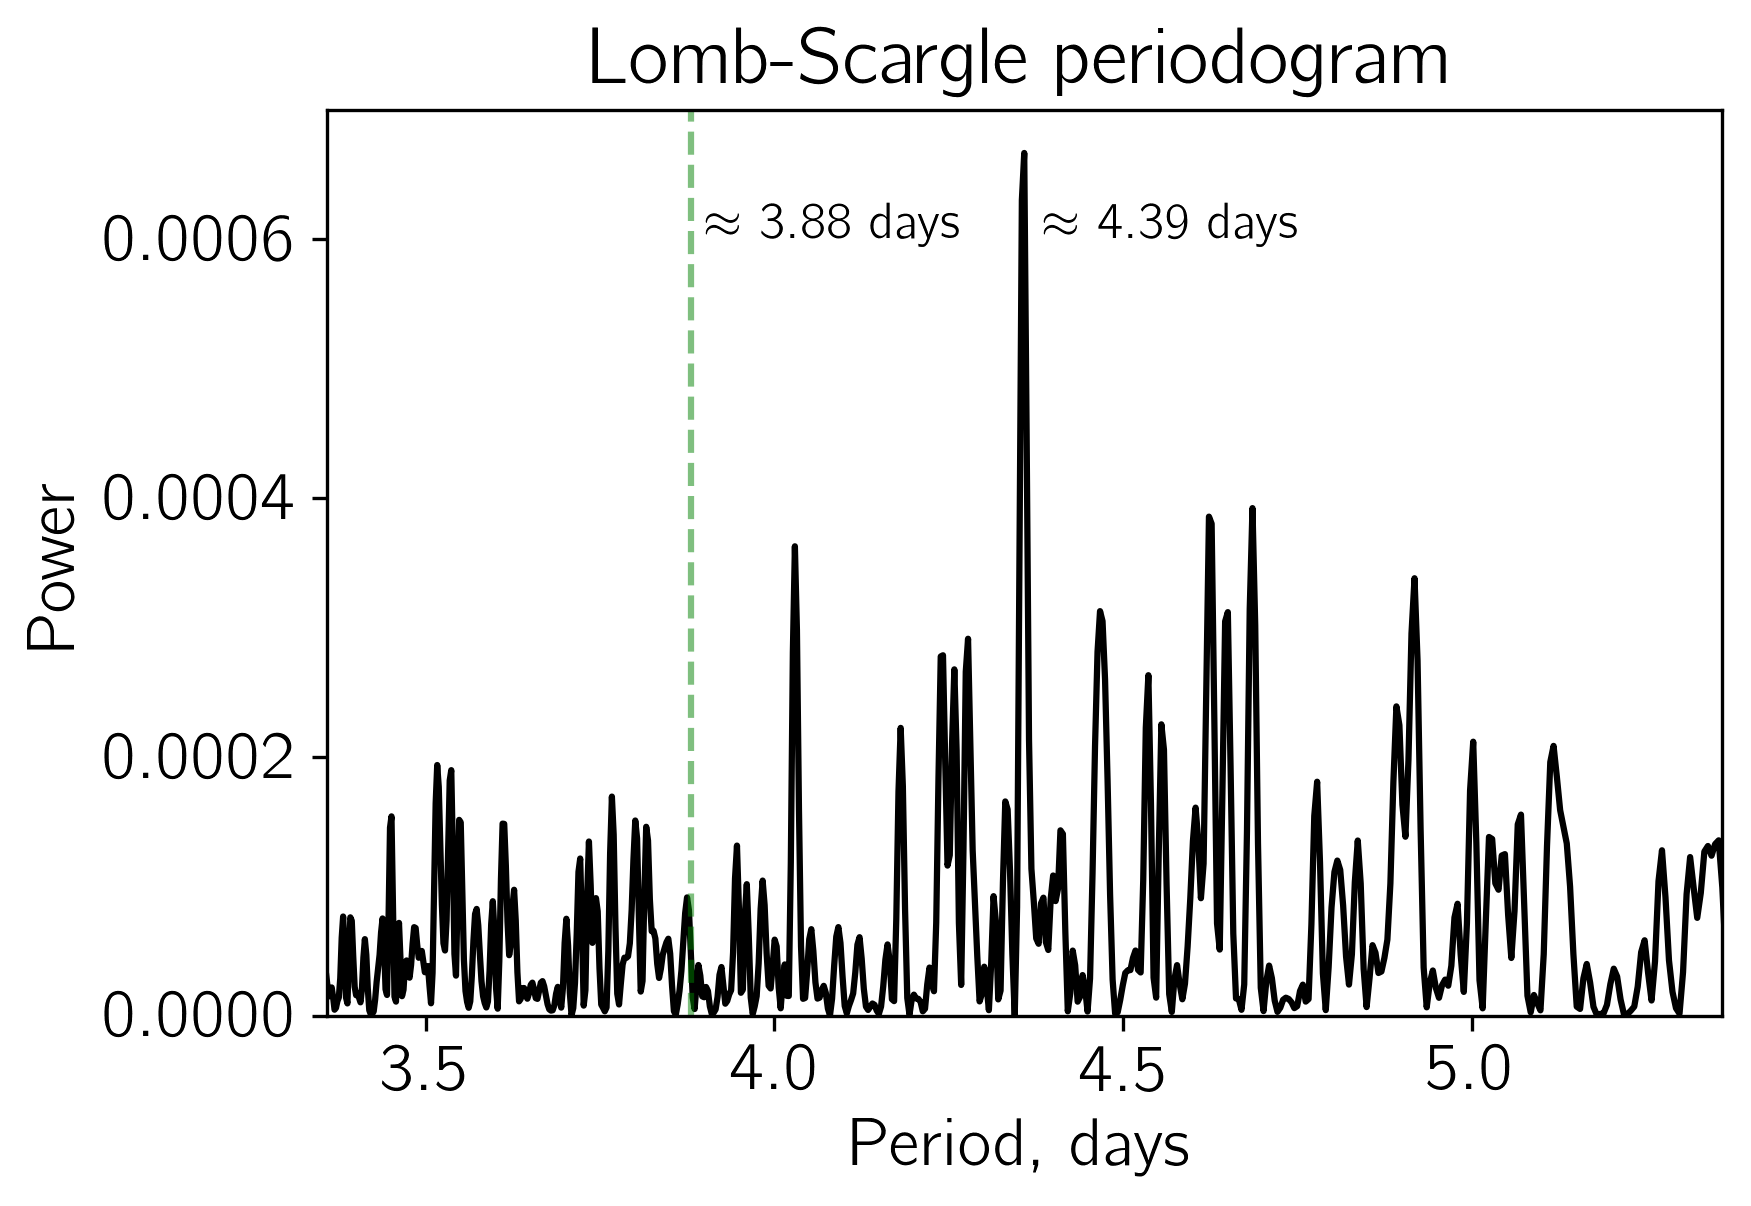

In [5]:
# Creating a set of evenly spaced frequencies 
freq = np.linspace(1e-1, 1.0, 5000)

# Getting the PSD-normalized Lomb-Scargle power spectrum of the data using the fast method (O[N log N])
power = LombScargle(t, f).power(freq, method="fast", normalization="psd")

# Determining the maximum peak
period = 1.0 / freq[np.argmax(power)]

# Scaling the output
power /= len(t)

# Plotting the result with emphasis on the period value
# and comparing it to the real value

## Plotting data
plt.plot(1.0 / freq, power, "k")

## Marking the true period value
plt.axvline(3.88, color="g", ls="dashed", alpha=0.5)

## Adding approximate period values on the plot
plt.text(3.9, 0.0006, r"$\approx$ 3.88 days", fontsize=12)
plt.text(4.385, 0.0006, r"$\approx$ 4.39 days", fontsize=12)

## Setting axis limits
plt.xlim(period - 1, period + 1)
plt.ylim(0, 0.0007)

## Setting labels
plt.xlabel("Period, days")
plt.ylabel("Power")
plt.title("Lomb-Scargle periodogram")

## Saving the figure
plt.savefig("figures/LSPeriodogram.png", bbox_inches="tight")